In [3]:
%reload_kedro
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

2021-06-07 10:44:12,994 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-06-07 10:44:13,021 - root - INFO - ** Kedro project Foehn fire impact
2021-06-07 10:44:13,022 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-06-07 10:44:13,030 - root - INFO - Registered line magic `run_viz`


In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sci
#from utils import *
import kedro.framework.context
import json
import os

plt.rcParams["figure.figsize"] = (16,9)
sns.set(font_scale=1.6)
sns.set_style("whitegrid")

In [6]:
df = context.catalog.load("fire_data_with_foehn_and_control_variables")

2021-06-07 10:44:29,033 - kedro.io.data_catalog - INFO - Loading data from `fire_data_with_foehn_and_control_variables` (CSVDataSet)...


In [7]:
df_foehn = context.catalog.load("foehn_data_prepared")

2021-06-07 10:44:30,108 - kedro.io.data_catalog - INFO - Loading data from `foehn_data_prepared` (CSVDataSet)...


In [8]:
df_foehn["year"] = df_foehn["date"].dt.year
df_foehn["month"] = df_foehn["date"].dt.month
df_foehn["day"] = df_foehn["date"].dt.day

In [11]:
regions = context.config_loader.get("regions.json")

In [27]:
print(r"\hline")
print(r"region & station & foehn presence [\%] & $\mathit{FFX}_{max}$ [km/h] & $\mathit{UU}_{min}$ [\%] \\")
print(r"\hline")

days_of_foehn = {}
for region, stations in regions.items():
    
    foehn_fraction_per_region = 0
    FFX_max = 0
    UU_min = 0
    if region == "north":
        print(r"\multirow{2}{*}{Southern Switzerland}", end = "")
    else:
        print(r"\multirow{2}{*}{Northern Switzerland}", end= "")
    for station in stations:
        if station in ["PIO", "LUG", "ALT", "CHU"]:
            years = df_foehn.loc[df_foehn[f"{station}_foehn"]==1, "year"].nunique()
            #print(station, ((df_foehn[["year", "month", "day", f"{station}_foehn"]].groupby(by=["year", "month", "day"]).sum()>18).sum()/years).values)#) > 6).sum()/years)
            days_of_foehn[station] = float((df_foehn[["year", "month", "day", f"{station}_foehn"]].groupby(by=["year", "month", "day"]).sum()>12).sum()/years)

            foehn_fraction = (df_foehn[f"{station}_foehn"] == 1).sum() / (df_foehn[f"{station}_foehn"].count())
            foehn_fraction_per_region += foehn_fraction  

            FFX_max = df_foehn.loc[df_foehn[f"{station}_foehn"] == 1, f"{station}_FFX"].max()
            #if temp > FFX_max: FFX_max = temp

            UU_min = df_foehn.loc[df_foehn[f"{station}_foehn"] == 1, f"{station}_UU"].min()
            if temp > UU_min: UU_min = temp    
    
            print(fr" & {station} & {round(foehn_fraction,3)} & {round(FFX_max,1)}  & {round(UU_min,1)} \\")
print(r"\hline")

\hline
region & station & foehn presence [\%] & $\mathit{FFX}_{max}$ [km/h] & $\mathit{UU}_{min}$ [\%] \\
\hline
\multirow{2}{*}{Southern Switzerland} & LUG & 0.056 & 119.9  & 6.9 \\
 & PIO & 0.133 & 110.2  & 6.9 \\
\multirow{2}{*}{Northern Switzerland} & CHU & 0.045 & 113.4  & 7.6 \\
 & ALT & 0.051 & 147.2  & 6.9 \\
\hline


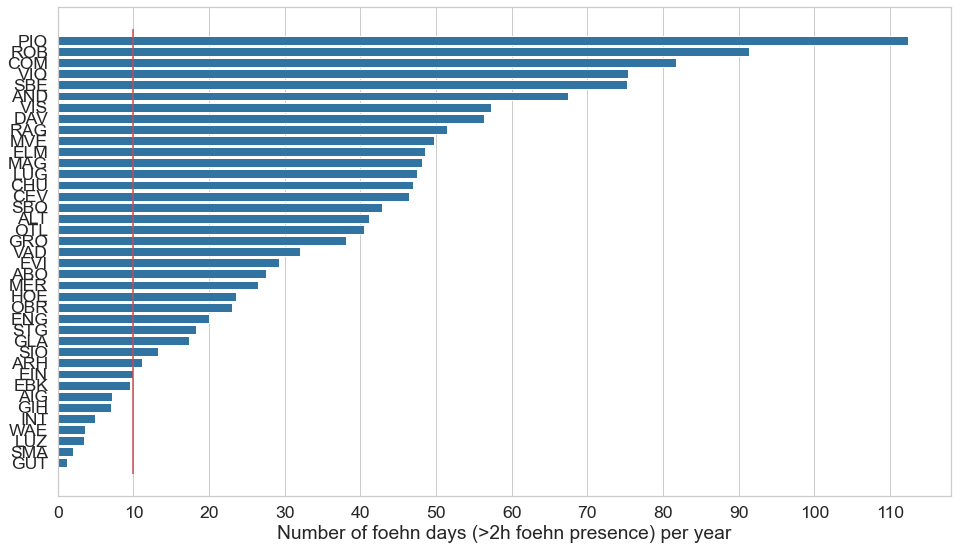

In [16]:
dummy = pd.DataFrame.from_dict(days_of_foehn, orient="index").sort_values(by=0, ascending=False)
dummy = dummy.reset_index()
sns.barplot(y=dummy["index"], x=dummy[0], color="tab:blue")
plt.xlabel("Number of foehn days (>2h foehn presence) per year")
plt.xticks(range(0,120+1,10))
plt.ylabel("")
plt.vlines(10, -1,39, color="r")

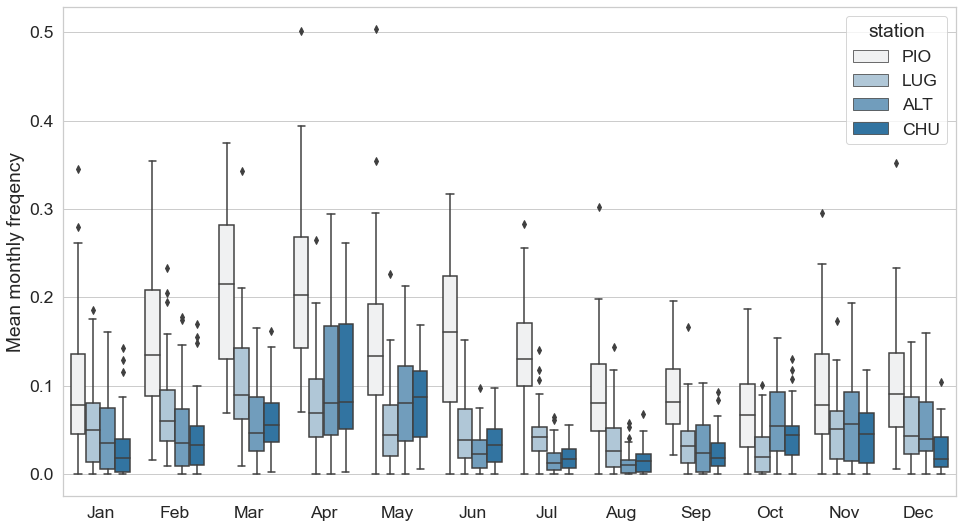

In [42]:
monthly_freqs = pd.DataFrame()
for station in [ "PIO", "LUG", "ALT", "CHU"]:
    
    group = df_foehn[["year", "month", f"{station}_foehn"]].groupby(by=["year", "month"], as_index=False)
    #print(group.min()["month"])
    month= group.min()["month"]

    freq = group.mean()[f"{station}_foehn"]
    #print(freq)
    dummy = pd.DataFrame({"month": month.values, "freq": freq.values})
    dummy["station"] = station
    
    monthly_freqs = pd.concat([monthly_freqs, dummy], axis=0)
    
ax = sns.boxplot(x="month", y="freq", data=monthly_freqs, hue="station", color="tab:blue")
plt.ylabel("Mean monthly freqency")
plt.xlabel("")
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]);
#save_figure(f"BoxplotFoehnFrequencies")
    